In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

PROJECT_ROOT = os.getcwd()
TRAIN_DIR = os.path.join(PROJECT_ROOT, "train")
VAL_DIR   = os.path.join(PROJECT_ROOT, "val")
TEST_DIR  = os.path.join(PROJECT_ROOT, "test")

BATCH_SIZE = 32
LR = 1e-4          # petit learning rate, c'est du transfer learning
EPOCHS = 10        # on commence simple
IMG_SIZE = 224     # EfficientNet-B0 travaille bien à 224x224

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=eval_tf)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=eval_tf)

num_classes = len(train_ds.classes)
class_names = train_ds.classes
print("Nombre de classes :", num_classes)
print("Exemples de classes :", class_names[:10])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Device: cuda
Nombre de classes : 38
Exemples de classes : ['apple_apple_scab', 'apple_black_rot', 'apple_cedar_apple_rust', 'apple_healthy', 'blueberry_healthy', 'cherry_healthy', 'cherry_powdery_mildew', 'corn_cercospora_leaf_spot_gray_leaf_spot', 'corn_common_rust', 'corn_healthy']


In [2]:
from torchvision.models import EfficientNet_B0_Weights

def build_efficientnet_b0(num_classes, freeze_backbone=True):
    # Charger modèle pré-entraîné ImageNet
    model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

    # Option : geler tout sauf la tête
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Remplacer la tête de classification finale
    in_features = model.classifier[1].in_features  # linear input dim
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

effnet_model = build_efficientnet_b0(num_classes, freeze_backbone=True).to(device)

print(effnet_model)
print(f"Paramètres ENTRAINABLES : {sum(p.numel() for p in effnet_model.parameters() if p.requires_grad):,}")
print(f"Paramètres TOTAUX       : {sum(p.numel() for p in effnet_model.parameters()):,}")


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [3]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    [p for p in effnet_model.parameters() if p.requires_grad],
    lr=LR
)

best_val_acc_eff = 0.0
effnet_best_path = os.path.join(PROJECT_ROOT, "efficientnet_b0_best.pth")

for epoch in range(1, EPOCHS+1):
    # ---- TRAIN ----
    effnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = effnet_model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / max(1, total)

    # ---- VAL ----
    effnet_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = effnet_model(x)
            preds = logits.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / max(1, val_total)

    print(f"[EfficientNet-B0][Epoch {epoch}/{EPOCHS}] Train Loss={train_loss:.4f} | Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}%")

    # sauvegarde meilleur modèle
    if val_acc > best_val_acc_eff:
        best_val_acc_eff = val_acc
        torch.save(effnet_model.state_dict(), effnet_best_path)
        print(f"✅ Nouveau meilleur EfficientNet sauvegardé ({val_acc:.2f}%) -> {effnet_best_path}")


[EfficientNet-B0][Epoch 1/10] Train Loss=2.1661 | Train Acc=57.75% | Val Acc=59.52%
✅ Nouveau meilleur EfficientNet sauvegardé (59.52%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\efficientnet_b0_best.pth
[EfficientNet-B0][Epoch 2/10] Train Loss=1.1279 | Train Acc=78.84% | Val Acc=73.28%
✅ Nouveau meilleur EfficientNet sauvegardé (73.28%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\efficientnet_b0_best.pth
[EfficientNet-B0][Epoch 3/10] Train Loss=0.7966 | Train Acc=83.52% | Val Acc=80.78%
✅ Nouveau meilleur EfficientNet sauvegardé (80.78%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\efficientnet_b0_best.pth
[EfficientNet-B0][Epoch 4/10] Train Loss=0.6335 | Train Acc=86.51% | Val Acc=84.75%
✅ Nouveau meilleur EfficientNet sauvegardé (84.75%) -> C:\Users\ENNHILI YASSINE\Desktop\CV_Project\efficientnet_b0_best.pth
[EfficientNet-B0][Epoch 5/10] Train Loss=0.5411 | Train Acc=88.18% | Val Acc=87.45%
✅ Nouveau meilleur EfficientNet sauvegardé (87.45%) -> C:\Users\ENNHILI YASSINE\Desk

In [4]:
# recharge le meilleur modèle EfficientNet-B0
effnet_eval = build_efficientnet_b0(num_classes, freeze_backbone=True).to(device)
effnet_eval.load_state_dict(torch.load(effnet_best_path, map_location=device))
effnet_eval.eval()

y_true_eff = []
y_pred_eff = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = effnet_eval(x)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_pred_eff.extend(list(preds))
        y_true_eff.extend(list(y.numpy()))

acc_eff = accuracy_score(y_true_eff, y_pred_eff) * 100
prec_eff = precision_score(y_true_eff, y_pred_eff, average="macro", zero_division=0) * 100
rec_eff  = recall_score(y_true_eff, y_pred_eff, average="macro", zero_division=0) * 100
f1_eff   = f1_score(y_true_eff, y_pred_eff, average="macro", zero_division=0) * 100

print("\n📊 Évaluation EfficientNet-B0 (test)")
print(f"Accuracy     : {acc_eff:.2f}%")
print(f"Précision    : {prec_eff:.2f}%")
print(f"Rappel       : {rec_eff:.2f}%")
print(f"F1-score     : {f1_eff:.2f}%")
print(f"(Checkpoint : {effnet_best_path})")



📊 Évaluation EfficientNet-B0 (test)
Accuracy     : 91.07%
Précision    : 90.23%
Rappel       : 90.15%
F1-score     : 89.59%
(Checkpoint : C:\Users\ENNHILI YASSINE\Desktop\CV_Project\efficientnet_b0_best.pth)


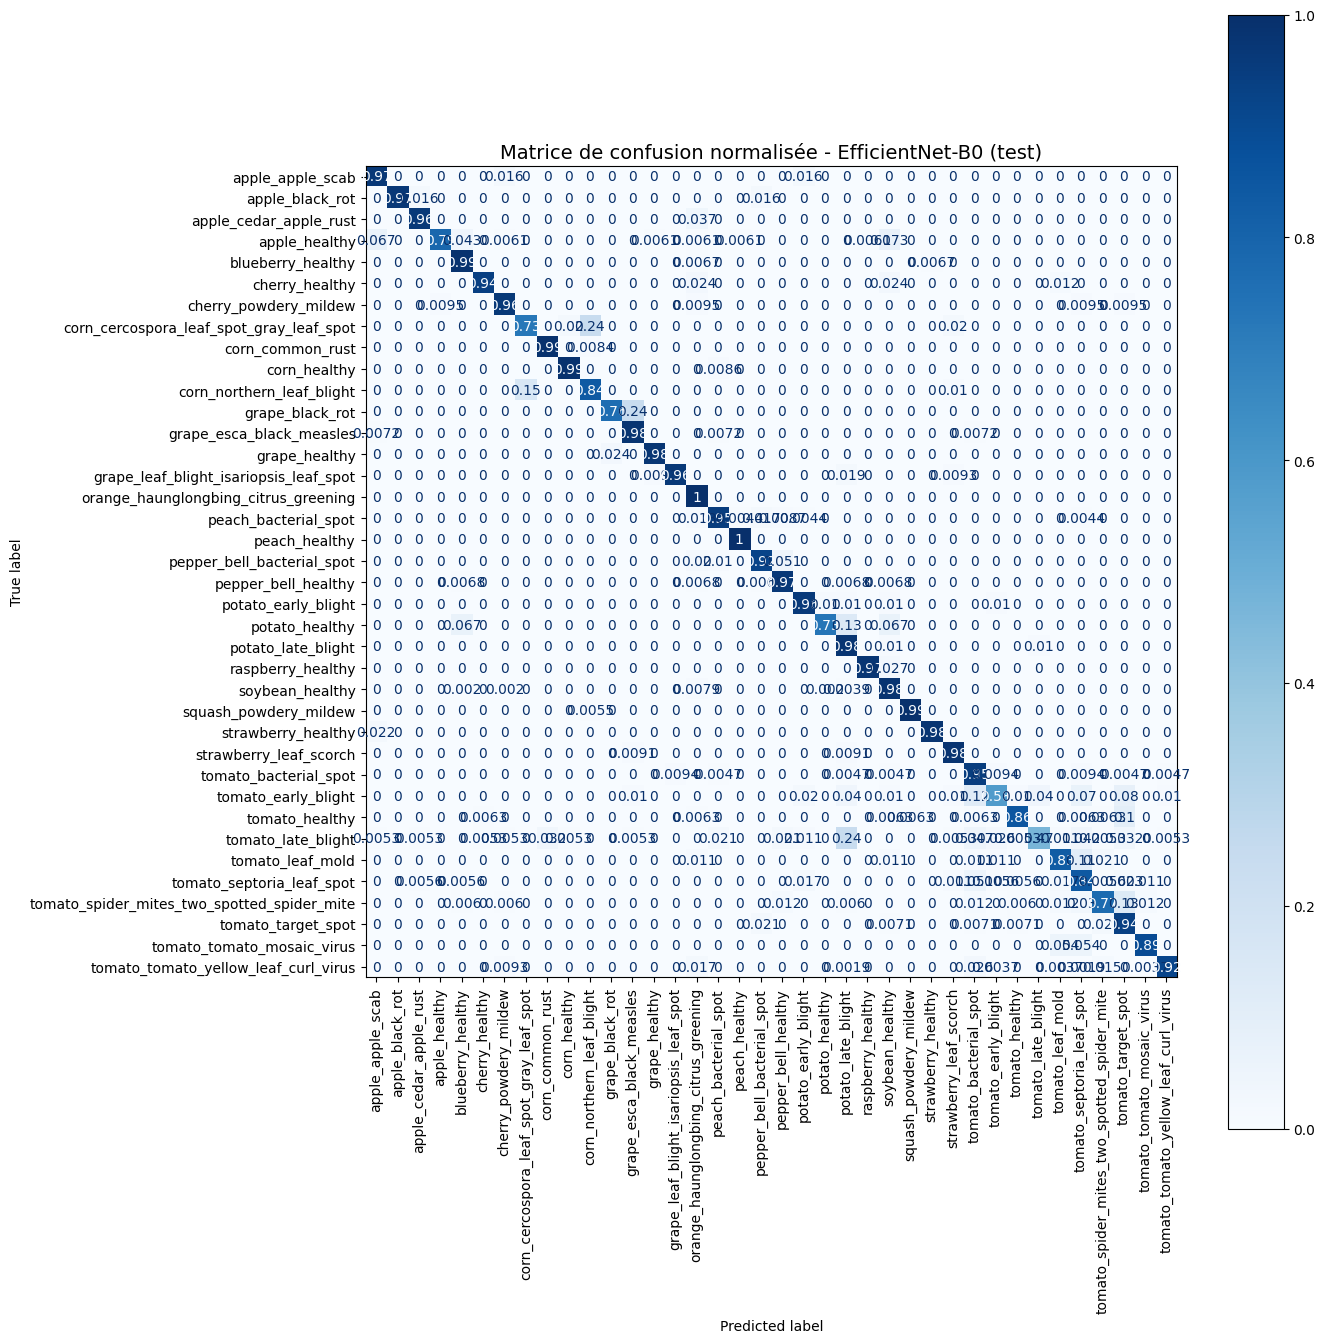

In [5]:
cm_eff = confusion_matrix(y_true_eff, y_pred_eff, normalize='true')

fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eff,
                              display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax, colorbar=True)

plt.title("Matrice de confusion normalisée - EfficientNet-B0 (test)", fontsize=14)
plt.tight_layout()
plt.show()
